In [1]:
import json
import numpy as np
import os
import cv2
import scipy.io as sio
import copy
import random
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import sys
from pathlib import Path
from math import cos, sin
sys.path.insert(0, "../")
from analyzer.camera_models import *  # our package
from utils.io import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

/home2/anders/miniconda3/envs/anders_torch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Init. params

In [2]:
DECIMALS =2
head_model = load_BFM("/home3/objects/calibration/BFM/BFM.mat")
shapeMU, shapePC, expPC = head_model["shapeMU"], head_model["shapePC"], head_model["expPC"]

In [3]:
N, C = shapeMU.shape
mean_face = np.reshape(shapeMU, (N//3, 3))

In [4]:
"""%matplotlib widget
fitted_vertices = np.load("/home3/objects/calibration/checker/ftv.npy")
min_vers = np.min(fitted_vertices, axis =0)
fitted_vertices -=min_vers
fig = plt.figure()
ax = Axes3D(fig)
plot_geeks = ax.scatter(fitted_vertices[:, 0], fitted_vertices[:, 1], fitted_vertices[:, 2], c = 'blue', alpha = 0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.FontSize = 20"""

'%matplotlib widget\nfitted_vertices = np.load("/home3/objects/calibration/checker/ftv.npy")\nmin_vers = np.min(fitted_vertices, axis =0)\nfitted_vertices -=min_vers\nfig = plt.figure()\nax = Axes3D(fig)\nplot_geeks = ax.scatter(fitted_vertices[:, 0], fitted_vertices[:, 1], fitted_vertices[:, 2], c = \'blue\', alpha = 0.8)\nax.set_xlabel(\'X\')\nax.set_ylabel(\'Y\')\nax.set_zlabel(\'Z\')\nax.FontSize = 20'

In [5]:
def draw_kps(img, kps):
    line_width = 10
    kps = kps.astype(np.int32)
    for l in range(kps.shape[0]):
        if 0 <= l < 17:
            color = [205, 133, 63]
        elif 17 <= l < 27:
            # eyebrows
            color = [205, 186, 150]
        elif 27 <= l < 39:
            # eyes
            color = [238, 130, 98]
        elif 39 <= l < 48:
            # nose
            color = [205, 96, 144]
        elif 48 <= l < 68:
            color = [0, 191, 255]
        if l in [0, 8, 16, 27, 30, 33, 36]:
            color = [0, 0, 255]
        cv2.circle(img, (kps[l][0], kps[l][1]), 15, color, -1)
        cv2.circle(img, (kps[l][0], kps[l][1]), 15,
                   (255, 255, 255), -1)
        if l not in [16, 21, 26, 32, 38, 42, 47, 59, 67]:
            start_point = (kps[l][0], kps[l][1])
            end_point = (kps[l + 1][0], kps[l + 1][1])
            cv2.line(img, start_point, end_point, (0, 0, 0),
                     line_width)
        elif l == 32:
            start_point = (kps[l][0], kps[l][1])
            end_point = (kps[27][0], kps[27][1])
            cv2.line(img, start_point, end_point, (0, 0, 0),
                     line_width)
        elif l == 38:
            start_point = (kps[l][0], kps[l][1])
            end_point = (kps[33][0], kps[33][1])
            cv2.line(img, start_point, end_point, (0, 0, 0),
                     line_width)
        elif l == 59:
            start_point = (kps[l][0], kps[l][1])
            end_point = (kps[48][0], kps[48][1])
            cv2.line(img, start_point, end_point, (0, 0, 0),
                     line_width)
        elif l == 67:
            start_point = (kps[l][0], kps[l][1])
            end_point = (kps[60][0], kps[60][1])
            cv2.line(img, start_point, end_point, (0, 0, 0),
                     line_width)

[[-3.00466765]
 [ 0.02058005]
 [-0.07888847]] [[-0.95725267]
 [-3.81638184]
 [35.77298361]]


<ipython-input-6-60232c8bbec6>:24: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


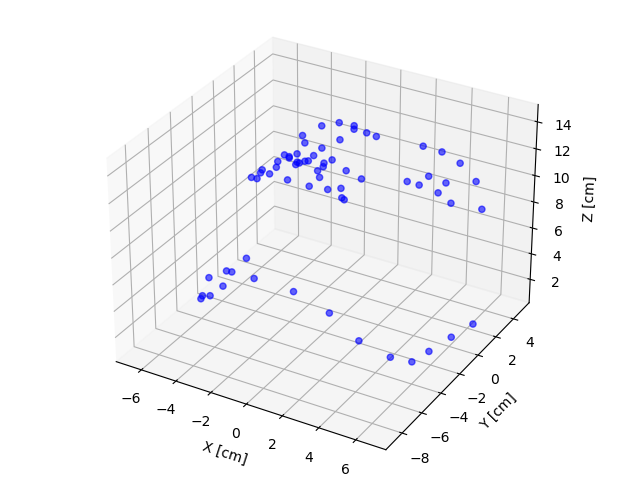

In [6]:
%matplotlib widget
annos =  load_json("/home3/objects/calibration/annos/BDD_calibrate_model.json")
frame = annos["frame_list"][0]
for lb in frame["labels"]:
    keypoints = lb["keypoints"]
    kps = np.asarray([keypoints[k] for k in keypoints])
    kps = kps[:, ::-1]
    copy_kps = kps
K = np.load("/home3/objects/calibration/checker/K.npy")
ftvs = np.load("/home3/objects/calibration/checker/ftv.npy")
valid_ind = np.load("/home3/objects/calibration/checker/valid_ind.npy")
s = np.load("/home3/objects/calibration/checker/s.npy")
R = np.load("/home3/objects/calibration/checker/R.npy")
t3d = np.load("/home3/objects/calibration/checker/t3d.npy")
ftvs = ftvs.reshape([-1])
ftvs = ftvs[valid_ind].reshape([-1, 3])
ftvs = 1e-4 * ftvs # to cm
(_, rotation_vector, translation_vector) = cv2.solvePnP(ftvs, 
                                                        kps, 
                                                        K, 
                                                        np.zeros((4, 1)))
print(rotation_vector, translation_vector)
fig = plt.figure()
ax = Axes3D(fig)
#plot_geeks = ax.scatter(kps[:, 0], kps[:, 1], kps[:, 2], c = 'blue', alpha = 0.8)
plot_geeks = ax.scatter(ftvs[:, 0],ftvs[:, 1], ftvs[:, 2], c = 'blue', alpha = 0.6)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.FontSize = 20
gt_pt = kps

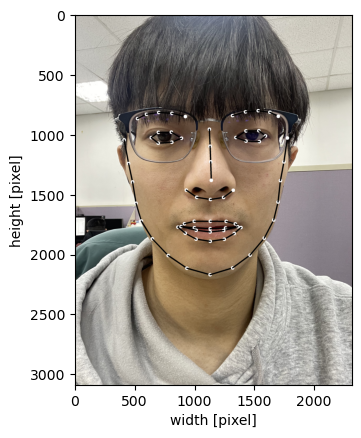

In [8]:
%matplotlib inline
img = mpimg.imread("/home3/objects/calibration/imgs/IMG_3485.jpg")
draw_kps(img, copy_kps)
plt.xlabel('width [pixel]')
plt.ylabel('height [pixel]')
imgplot = plt.imshow(img)
plt.show()

In [36]:
img = mpimg.imread("/home3/objects/calibration/imgs/IMG_3485.jpg")
annos =  load_json("/home3/objects/calibration/annos/BDD_calibrate_model.json")
ftvs = np.load("/home3/objects/calibration/checker/ftv.npy")
valid_ind = np.load("/home3/objects/calibration/checker/valid_ind.npy")
K = np.load("/home3/objects/calibration/checker/K.npy")
ftvs = ftvs.reshape([-1])
ftvs = ftvs[valid_ind].reshape([-1, 3])
ftvs = 1e-4*ftvs
rt_pts = ftvs
frame = annos["frame_list"][0]
for lb in frame["labels"]:
    keypoints = lb["keypoints"]
    kps = np.asarray([keypoints[k] for k in keypoints])
    kps = kps[:, ::-1]
    copy_kps = kps
kps = np.concatenate([kps, np.ones(shape = (kps.shape[0], 1))], axis =-1)
#inv_K = np.linalg.inv(K)
#kps = kps.dot(inv_K.T)
gt_pt = kps
params = tf.Variable(initial_value= [5, 5, 50], dtype=tf.float32)[:, None]

In [37]:
@tf.function
def calc_mean_error(preds, gts):
    errs = preds - gts
    return tf.math.reduce_mean(errs**2)
@tf.function
def camera_model(kps, K, Rt):
    preds = tf.linalg.matmul(kps, Rt, transpose_b=True)
    preds = tf.reshape(preds, [68, 3])
    preds = tf.linalg.matmul(preds, K, transpose_b=True)
    preds /= preds[:, -1:]
    return preds
def get_R(angles):
    x, y, z = angles[0], angles[1], angles[2]
    a1 = tf.constant([1, 0, 0], shape=(3, 1), dtype=tf.dtypes.float32)

    a2 = tf.concat([
        tf.zeros(shape=(1, 1)),
        tf.math.cos(x)[None, None, ], -tf.math.sin(x)[None, None, ]
    ],
                   axis=-0)
    a3 = tf.concat([
        tf.zeros(shape=(1, 1)),
        tf.math.sin(x)[None, None, ],
        tf.math.cos(x)[None, None, ]
    ],
                   axis=0)

    Rx = tf.concat([a1, a2, a3], axis=-1)
    b1 = tf.concat([
        tf.math.cos(y)[None, None, ],
        tf.zeros(shape=(1, 1)),
        tf.math.sin(y)[None, None, ]
    ],
                   axis=0)
    b2 = tf.constant([0, 1, 0], shape=(3, 1), dtype=tf.dtypes.float32)
    b3 = tf.concat([
        -tf.math.sin(y)[None, None, ],
        tf.zeros(shape=(1, 1)),
        tf.math.cos(y)[None, None, ]
    ],
                   axis=0)
    Ry = tf.concat([b1, b2, b3], axis=-1)

    c1 = tf.concat([
        tf.math.cos(z)[None, None, ], -tf.math.sin(z)[None, None, ],
        tf.zeros(shape=(1, 1))
    ],
                   axis=0)

    c2 = tf.concat([
        tf.math.sin(z)[None, None, ], -tf.math.cos(z)[None, None, ],
        tf.zeros(shape=(1, 1))
    ],
                   axis=0)
    c3 = tf.constant([0, 0, 1], shape=(3, 1), dtype=tf.dtypes.float32)
    Rz = tf.concat([c1, c2, c3], axis=-1)
    return tf.linalg.matmul(Rz, tf.linalg.matmul(Ry, Rx))


angles = tf.constant([-3.00466765, 0.02058005, -0.07888847], dtype=tf.float32)


h, w, c = img.shape
img_wh = tf.constant([h, w], shape = (1, 2), dtype=tf.float32)

R = get_R(angles)
td_pts = tf.cast(rt_pts, tf.float32)
td_pts = tf.concat([td_pts, tf.ones(shape = (td_pts.shape[0], 1))], axis =-1)
K = tf.cast(K, tf.float32)
gt_pt = tf.cast(gt_pt, tf.float32)
lr = 0.0000025
epochs = int(1e4)
gt_pt = gt_pt / gt_pt[:, -1:]
gt_pt = gt_pt[:, :2] / img_wh

for i in range(epochs):
    with tf.GradientTape() as tape:
        tape.watch(params)
        Rt = tf.concat([R, params], axis =-1)
        preds = camera_model(td_pts, K, Rt)
        preds = preds[:, :2] / img_wh
        loss = calc_mean_error(preds,  gt_pt)
    gradients  = tape.gradient(loss, params)
    params = params - lr * gradients
    if i % 1000 == 0:
        print('=' * 50)
        print("Epoch {} loss is {}\n".format(i, loss))
print("Final linear transform matrix")
print(params)

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
Epoch 0 loss is 0.07361890375614166

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Ten

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
Epoch 3000 loss is 0.07361890375614166

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [-0.00189305]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[ 0.00292516]
 [ 0.00601279]
 [

KeyboardInterrupt: 

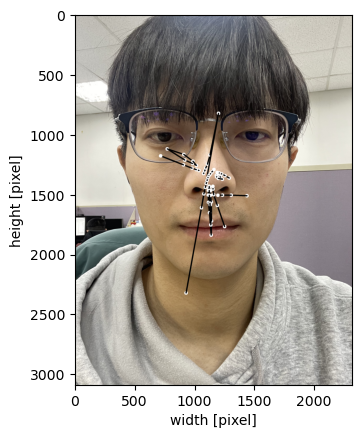

In [27]:
img = mpimg.imread("/home3/objects/calibration/imgs/IMG_3485.jpg")
preds = tf.linalg.matmul(td_pts, params, transpose_b=True)
preds =  tf.linalg.matmul(preds, K, adjoint_b=True)
preds /= preds[:, -1:]
preds = preds.numpy()
%matplotlib inline
draw_kps(img, preds)
imgplot = plt.imshow(img)
plt.xlabel('width [pixel]')
plt.ylabel('height [pixel]')
plt.show()

<ipython-input-24-a9d7e237989f>:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


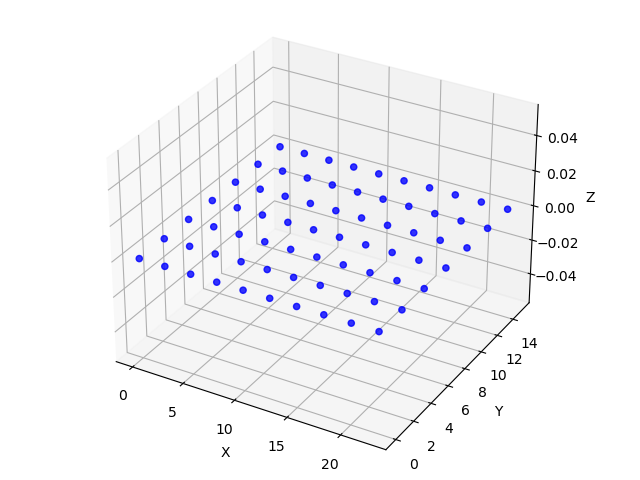

In [24]:
%matplotlib widget
origin_pts = np.load("/home3/objects/calibration/box/origin_pts.npy")
pts = np.load("/home3/objects/calibration/box/rt_pts.npy")
fig = plt.figure()
ax = Axes3D(fig)

#plot_geeks = ax.scatter(pts[:, 0],pts[:, 1], pts[:, 2], c = 'red', alpha = 0.8)
plot_geeks = ax.scatter(origin_pts[:, 0],origin_pts[:, 1], origin_pts[:, 2], c = 'blue', alpha = 0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.FontSize = 20

# Roation drawing axis

In [59]:
print(C)
THETA_X = np.pi / 2  # roll angle
THETA_Z = np.pi  # yaw angle
R = get_rotation_matrix(theta_x=THETA_X, theta_z=THETA_Z)
new_C = R @ C
PX, PZ, PY  = new_C 
print("=" * 100)
print("Rotation")
print(f"PX:\n{PX}")
print(f"PY:\n{PY}")
print(f"PY:\n{PZ}")

[   11.65113624    15.50440848 -3000.        ]
Rotation
PX:
-11.651136239116397
PY:
15.504408482380327
PY:
-3000.0


In [60]:
world_origin = np.zeros(3)
pose_origin = world_origin + np.array([0, 0, 0]) 
dx, dy, dz = np.eye(3)
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)

camera_frame = ReferenceFrame(
    origin=new_C, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=camera_frame.origin,
    camera_dz=camera_frame.dz,
    f=F2cm,
)

image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=R @ dx, 
    dy=R @ dy,
    dz=R @ dz,
    name="Image",
)
image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)

/home2/anders/proj_py/behaviornet/analyzer/../analyzer/camera_models/_frame.py:34: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection="3d")
/home2/anders/proj_py/behaviornet/analyzer/../analyzer/camera_models/_image.py:55: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projectio

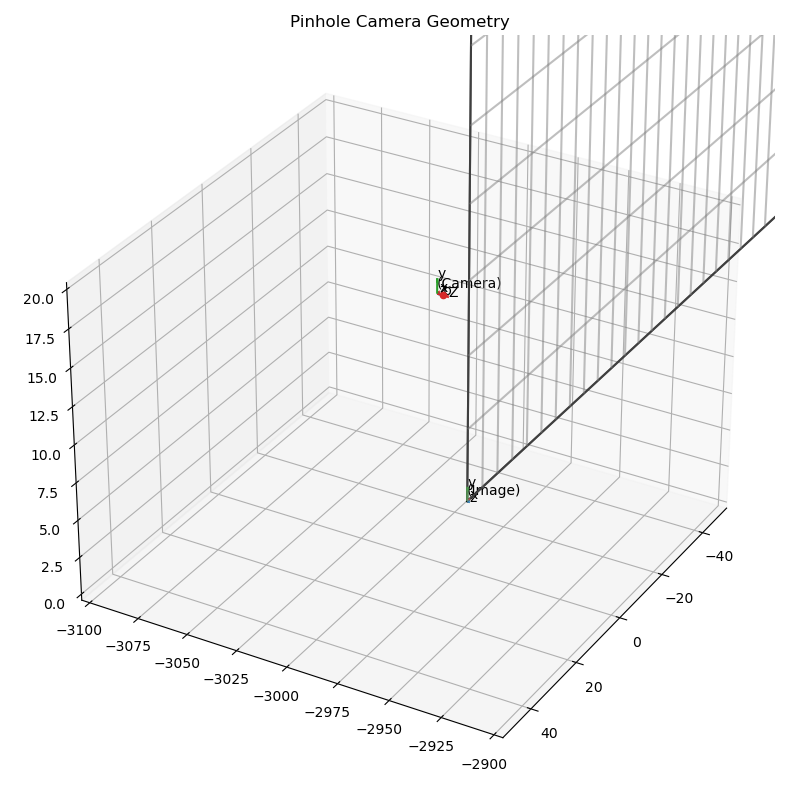

In [75]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.text(*(C), "C")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
image_plane.draw3d()
Z.draw3d()
ax.view_init(elev=30.0, azim=30.0)
ax.set_title("Pinhole Camera Geometry")
ax.set_xlim (-50, 50)
ax.set_ylim (-3100, -2900)
ax.set_zlim (0, 20)
plt.tight_layout()
plt.show()

In [79]:
X = np.array([50, 50, 50])
X = R @ X
G = GenericPoint(X, name="X")
L = get_plucker_matrix( C, X)
X1 = image_frame.origin
X2 = X1 + image_frame.dx
X3 = X1 + image_frame.dy
pi = get_plane_from_three_points(X1, X2, X3)
x = to_inhomogeneus(L @ pi)
print(f"X:\n{X}")
print(f"\nL:\n{L.round(DECIMALS)}")
print(f"\nX1:\n{X1}")
print(f"\nX2:\n{X2}")
print(f"\nX3:\n{X3}")
print(f"\npi:\n{pi.round(DECIMALS)}")
print(f"\nx:\n{x.round(DECIMALS)}")

X:
[-50.  50.  50.]

L:
[[    0.     0. -2500.    50.]
 [   -0.     0.  2500.   -50.]
 [ 2500. -2500.     0.  -100.]
 [  -50.    50.   100.     0.]]

X1:
[ 25. -40. -25.]

X2:
[ 24. -40. -25.]

X3:
[ 25. -40. -24.]

pi:
[ 0.  1.  0. 40.]

x:
[  40.  -40. -130.]


/home2/anders/proj_py/behaviornet/analyzer/../analyzer/camera_models/_frame.py:34: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection="3d")
/home2/anders/proj_py/behaviornet/analyzer/../analyzer/camera_models/_principal_axis.py:31: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(

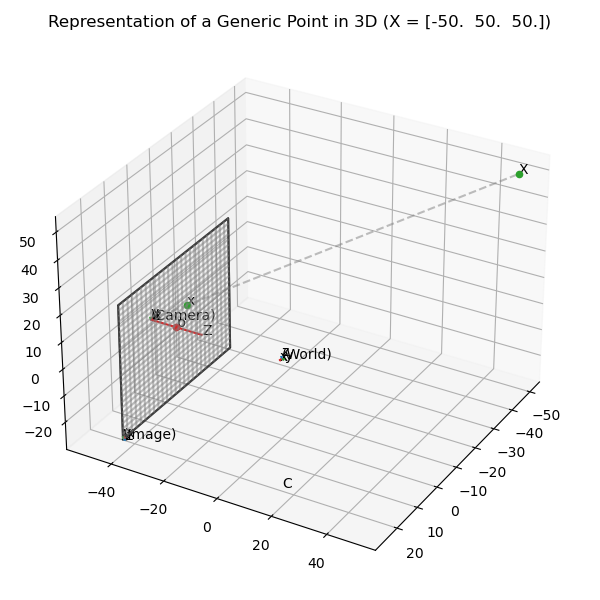

In [81]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
ax.text(*C, "C")
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()
G.draw3d(pi, C= R @ C)
ax.view_init(elev=30.0, azim=30.0)
ax.set_title(f"Representation of a Generic Point in 3D (X = {X})")
plt.tight_layout()
plt.show()

In [ ]:
# square1.draw3d(pi=image_plane.pi, C=camera_origin)
# square2.draw3d(pi=image_plane.pi, C=camera_origin, color="tab:purple")

"""
vertices = R @ fitted_vertices.T
vertices = vertices.T
ax.plot(vertices[:17, 0], vertices[:17, 1], zs = vertices[:17, 2], color = "black", alpha = 0.6)
ax.plot(vertices[17:22, 0], vertices[17:22, 1], zs = vertices[17:22, 2], color = "black", alpha = 0.6)
ax.plot(vertices[22:27, 0], vertices[22:27, 1], zs = vertices[22:27, 2], color = "black", alpha = 0.6)
ax.plot(vertices[27:33, 0], vertices[27:33, 1], zs = vertices[27:33, 2], color = "black", alpha = 0.6)
ax.plot(vertices[33:39, 0], vertices[33:39, 1], zs = vertices[33:39, 2], color = "black", alpha = 0.6)
ax.plot(vertices[39:43, 0], vertices[39:43, 1], zs = vertices[39:43, 2], color = "black", alpha = 0.6)
ax.plot(vertices[43:48, 0], vertices[43:48, 1], zs = vertices[43:48, 2], color = "black", alpha = 0.6)
ax.plot(vertices[48:60, 0], vertices[48:60, 1], zs = vertices[48:60, 2], color = "black", alpha = 0.6)
ax.plot(vertices[60:68, 0], vertices[60:68, 1], zs = vertices[60:68, 2], color = "black", alpha = 0.6)
for i in range(68):
    if i in [0, 8, 16, 27, 30, 33, 36]:
        plot_geeks = ax.scatter(vertices[i, 0], vertices[i, 1], vertices[i, 2], c = 'red', alpha = 0.8)
    elif i < 17:
        plot_geeks = ax.scatter(vertices[i, 0], vertices[i, 1], vertices[i, 2], c = 'blue', alpha = 0.8)
    elif 17 <= i < 27:
        plot_geeks = ax.scatter(vertices[i, 0], vertices[i, 1], vertices[i, 2], c = 'grey', alpha = 0.8)
    elif 27 <= i < 39:
        plot_geeks = ax.scatter(vertices[i, 0], vertices[i, 1], vertices[i, 2], c = 'steelblue', alpha = 0.8)
    elif 39 <= i < 48:
        plot_geeks = ax.scatter(vertices[i, 0], vertices[i, 1], vertices[i, 2], c = 'orchid', alpha = 0.8)
    elif 48 <= i < 68:
        plot_geeks = ax.scatter(vertices[i, 0], vertices[i, 1], vertices[i, 2], c = 'gold', alpha = 0.8)
"""
